In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
# reflect the tables
Base = automap_base()
Base.prepare(engine, reflect=True)


In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Climate Analysis

In [10]:
# Inspecting data in measurement table
inspector = inspect(engine)
inspector.get_table_names()

engine.execute('SELECT * FROM measurement WHERE date > \'2017-01-01\'ORDER BY date LIMIT 5').all()


[(2496, 'USC00519397', '2017-01-02', 0.0, 66.0),
 (5223, 'USC00513117', '2017-01-02', 0.0, 66.0),
 (7442, 'USC00514830', '2017-01-02', 0.01, 74.0),
 (14740, 'USC00519281', '2017-01-02', 0.01, 70.0),
 (19330, 'USC00516128', '2017-01-02', 0.0, 70.0)]

In [11]:
# Inspecting columns in measurement table
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# Inspecting data in station table
inspector = inspect(engine)
inspector.get_table_names()

engine.execute('SELECT * FROM station').all()


[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [13]:
# Inspecting columns in measurement table
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


Text(0, 0.5, 'Inches')

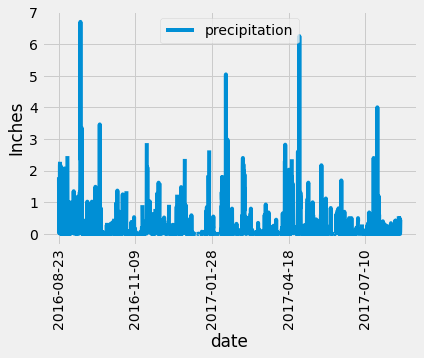

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
one_year_ago_date = dt.date(2017, 8 , 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date

data_df = pd.DataFrame(data, columns=["date", "precipitation"])

data_df.set_index(data_df['date'], inplace=False)

data_df = data_df.sort_values("date")

data_df.plot('date', 'precipitation',rot=90)
plt.ylabel("Inches")

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
stats = data_df.describe()
stats

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Design a query to show how many stations are available in this dataset?
station_no = session.query(Measurement).group_by(Measurement.station).count()
print(f"The total number of station is {station_no}")

The total number of station is 9


In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_name = session.query(Measurement.station , Station.name, func.count(Measurement.station)).\
    filter(Measurement.station == Station.station).group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).limit(10).all()

for x in station_name:
    (s, n, c) = x
    print(f"Station: {s}, Name: {n}, Count: {c}")

print("Station with the highest number of observations is station USC00519281, name: WAIHEE 837.5, HI US")


Station: USC00519281, Name: WAIHEE 837.5, HI US, Count: 2772
Station: USC00519397, Name: WAIKIKI 717.2, HI US, Count: 2724
Station: USC00513117, Name: KANEOHE 838.1, HI US, Count: 2709
Station: USC00519523, Name: WAIMANALO EXPERIMENTAL FARM, HI US, Count: 2669
Station: USC00516128, Name: MANOA LYON ARBO 785.2, HI US, Count: 2612
Station: USC00514830, Name: KUALOA RANCH HEADQUARTERS 886.9, HI US, Count: 2202
Station: USC00511918, Name: HONOLULU OBSERVATORY 702.2, HI US, Count: 1979
Station: USC00517948, Name: PEARL CITY, HI US, Count: 1372
Station: USC00518838, Name: UPPER WAHIAWA 874.3, HI US, Count: 511
Station with the highest number of observations is station USC00519281, name: WAIHEE 837.5, HI US


In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

most_active_station = "USC00519281"

lowest_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == most_active_station)
for x in lowest_temp:
    print(f"lowest temp is {x[0]}")


lowest temp is 54.0


In [19]:
highest_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == most_active_station)
for x in highest_temp:
    print(f"highest temp is {x[0]}")

highest temp is 85.0


In [20]:
av_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station)
for x in av_temp:
    print(f"average temp is {round(x[0],1)}")

average temp is 71.7


('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


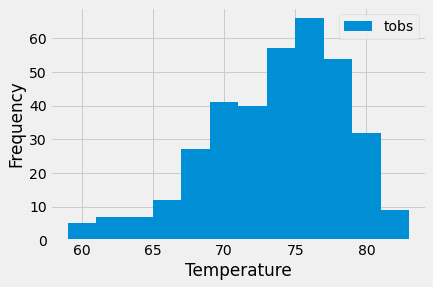

In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

station_count2 = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc())

for x in station_count2:
    print(x)

highest_temp_observe_station = "USC00519281"


# Calculate the date 1 year ago for station USC00519281 from the last data point in the database
last_date2 = session.query(Measurement.date).filter(Measurement.station == "USC00519281").\
    order_by(Measurement.date.desc()).first()

# last_date2 = 2017-08-18

one_year_ago_date2 = dt.date(2017, 8 , 18) - dt.timedelta(days=365)

data2 = session.query(Measurement.date , Measurement.tobs).filter(Measurement.station == highest_temp_observe_station).\
    filter(Measurement.date>=one_year_ago_date2).all()

data2_df = pd.DataFrame(data2, columns=("Date","Temperature"))

temp_data = data2_df["Temperature"].tolist()

plt.hist (temp_data,bins=12,label="tobs")
plt.ylabel("Frequency")
plt.xlabel("Temperature")
plt.legend()
plt.show()



In [22]:
# Choose a start date and end date for your trip. Make sure that your vacation range is approximately 3-15 days total.

start_date = dt.date (2017,1,1)
end_date = dt.date (2017,1,10)

# create dataframe for daily temp and prcp between start date and end date
weather = session.query(Measurement.date, Measurement.tobs, Measurement.prcp).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= start_date).filter(func.strftime("%Y-%m-%d", Measurement.date) <= end_date).all()
    
weather_df = pd.DataFrame(weather, columns= ("date", "temp", "prcp"))

# calculate min, av, max temp between start date and end date    
weather2 = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= start_date).filter(func.strftime("%Y-%m-%d", Measurement.date) <= end_date).all()
    
weather_list2 = list(np.ravel(weather2))

# display result
print(f"between {start_date} and {end_date}, min temp is {weather_list2[0]}, av temp is {weather_list2[1]}, max temp is {weather_list2[2]}")
weather_df.head()





between 2017-01-01 and 2017-01-10, min temp is 60.0, av temp is 68.0327868852459, max temp is 77.0


,date,temp,prcp
0,2017-01-01,62.0,0.0
1,2017-01-02,66.0,0.0
2,2017-01-03,63.0,0.0
3,2017-01-04,62.0,0.0
4,2017-01-05,63.0,0.0


## Bonus Challenge Assignment

In [36]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2017-01-01', '2017-01-10'))

[(60.0, 68.0327868852459, 77.0)]


In [41]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).all()

# function usage example
print(calc_temps('2017-01-01'))

[(58.0, 74.14387974230493, 87.0)]


In [24]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [25]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [26]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [27]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [28]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [29]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [30]:
# Plot the daily normals as an area plot with `stacked=False`
